### This notebook will show you how to perform statistics on a single or multiple samples.

### 1. Run a script to format the data

In [1]:
# Help page of the script
!python REMAP.processing.v1.py -h

usage:  [-h] [-i INPUT] [-o OUTPUT] [-P PROCESS] [-c COVERAGE]
        [--c2 COVERAGE2] [-l MINIMUM_LEVEL] [--bedtools BEDTOOLS] [-f FASTA]
        [-t TSS_DB] [-e EXONS_DB] [-a ANNOT]

optional arguments:
  -h, --help            show this help message and exit

Required:
  -i INPUT              Input list
  -o OUTPUT, --output OUTPUT
                        Output prefix
  -P PROCESS            Process number, default=4
  -c COVERAGE, --coverage COVERAGE
                        Coverage cutoff for site filtering, default=50
  --c2 COVERAGE2, --coverage2 COVERAGE2
                        Coverage cutoff for concaternating, default=50
  -l MINIMUM_LEVEL, --level MINIMUM_LEVEL
                        Cutoff for extra base levels, default=0.1
  --bedtools BEDTOOLS   Bedtools directory
  -f FASTA, --fasta FASTA
                        Fasta file containing the names
  -t TSS_DB, --tss TSS_DB
  -e EXONS_DB, --exons EXONS_DB
  -a ANNOT, --annot ANNOT


Here, we need to provide the following metadata: 

* -f The FASTA file for the reference genome
* -e BED file containing the cooridinates of the first exons of genes
* -a An annotation file similar to the table generated by UCSC Table Browser

You can refer to the TSS annotation pipeline here to get the metadata: https://github.com/jhfoxliu/ReCappable-seq/tree/main/Notebook/TSS_annotations/ANNOTATIONS

We also need a samplesheet for all your inputs. Here, we have two samples, A549_rep1 and HepG2_rep1. Please note that the first column is sample names, the second column is the related CSV file generated by the mapping pipeline.

In [2]:
!cat Samples.txt

A549_rep1	A549_rep1.expansions.csv
HepG2_rep1	HepG2_rep1.expansions.csv


Before use, please have the following modifications:

1. Specify the directory of bedtools wiht --bedtools.
2. Specify the directory of related scripts (`collaspe_bed_annotations_v3.py`, `collaspe_bed_annotations_fix_other_exons_v2.py`, `collaspe_bed_annotations_fix_upstream_TSS.py`) in the script `REMAP.processing.v1.py`, or just put them together under the same folder.


Now run the script.We will use two processors (-P 2), and requires at least 100 reads (-c 100). (--c2 not functional, but related to the name of the output, just make sure --c and --c2 have the same values. I am lazy to change them :( ). The output will has the prefix of "test_out" (-o test_out). 

I ignored the flags for metadata here. Please use those flags or modify the file to change the default.


In [3]:
!python REMAP.processing.v1.py -i Samples.txt -P 2 -c 100 --c2 100 -o test_out

[2025-06-27 14:15:25] Analysis begins.
[2025-06-27 14:15:25] Looking for extra bases...
[2025-06-27 14:15:30] Merging tables...
[2025-06-27 14:15:31] Data fetching ends. Start annotation.
/home/fox/Software/bedtools/2.29.1/bedtools sort -i 1603542.bed > 1603542.sorted.bed
/home/fox/Software/bedtools/2.29.1/bedtools closest -s -D b -a 1603542.sorted.bed -b /home/fox/Database/Genome/Human/Gencode/v45/gencode.v45.primary_assembly.annotation.nochr.tss.bed > 1603542.closest_tss.bed
/home/fox/Software/bedtools/2.29.1/bedtools closest -S -D b -a 1603542.sorted.bed -b /home/fox/Database/Genome/Human/Gencode/v45/gencode.v45.primary_assembly.annotation.nochr.tss.bed > 1603542.closest_tss.upstream.bed
/home/fox/Software/bedtools/2.29.1/bedtools closest -s -D b -a 1603542.sorted.bed -b /home/fox/Database/Genome/Human/Gencode/v45/gencode.v45.primary_assembly.annotation.nochr.tx.bed > 1603542.closest_exons.bed
[2025-06-27 14:15:38] Done!


In [4]:
!ls test_out*

test_out_coverages_cov100_level0.1.csv	 test_out_fractions.csv
test_out_extrabases_cov100_level0.1.csv


Here, 

`{output}_coverages_cov100_level0.1.csv` describes the number of reads per TSS.

`{output}_extrabases_cov100_level0.1.csv` describes the degree of expansions (average expansion per read) per TSS.

`{output}_fractions.csv` describes the fraction of expanded transcripts per TSS.

Let's have a look at the `{output}_extrabases_cov100_level0.1.csv` .

### 2. Have some plots

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.ticker as ticker
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

In [6]:
df = pd.read_csv("test_out_extrabases_cov100_level0.1.csv", index_col=[0, 1, 2], header=0, low_memory=False)

In [7]:
df

A549_rep1  HepG2_rep1          N20         N10    N4  \
chr pos       strand                                                         
1   1407293   -        0.851613    0.510417  ATTTCCGACCC  ATTTCCGACC  ATTT   
    6199594   -        0.321101    0.301075  CTTTCTAACTC  CTTTCTAACT  CTTT   
    7961717   +        0.000000    0.117391  ATTTTCAGCCT  ATTTTCAGCC  ATTT   
    11012654  +        0.959596    0.214123  ATTTTGTGGGA  ATTTTGTGGG  ATTT   
    16367243  +        0.464968    0.382979  AAAGCGGCGAG  AAAGCGGCGA  AAAG   
...                         ...         ...          ...         ...   ...   
X   71533104  +             NaN    0.633333  ATTTCAAGACC  ATTTCAAGAC  ATTT   
    115702792 +             NaN    0.742857  CTTTCTTTGCG  CTTTCTTTGC  CTTT   
    132413604 -             NaN    0.488038  AAATTTCCTTG  AAATTTCCTT  AAAT   
    133985580 -             NaN    0.389513  AAACTTTTGCA  AAACTTTTGC  AAAC   
Y   1392112   -             NaN    0.345455  CTTTCGGTCCA  CTTTCGGTCC  CTTT   

                         Gene          Gene_biotype Annotate_to_closest  
chr pos       strand                                                     
1   1407293   -        MRPL20        protein_coding                 TSS  
    6199594   -         RPL22        protein_coding                 TSS  
    7961717   +         PARK7        protein_coding                 TSS  
    11012654  +        TARDBP        protein_coding                 TSS  
    16367243  +         SZRD1        protein_coding                 TSS  
...                       ...                   ...                 ...  
X   71533104  +           OGT        protein_coding                 TSS  
    115702792 +       EEF1GP5  processed_pseudogene                 TSS  
    132413604 -         MBNL3        protein_coding                 TSS  
    133985580 -          GPC3        protein_coding                 TSS  
Y   1392112   -       SLC25A6        protein_coding                 TSS  

[649 rows x 8 columns]

In [8]:
## We only use the sites annotated around regular TSSs
df = df[df["Annotate_to_closest"] == "TSS"]

# We also only check protein coding genes
df = df[df["Gene_biotype"] == "protein_coding"]


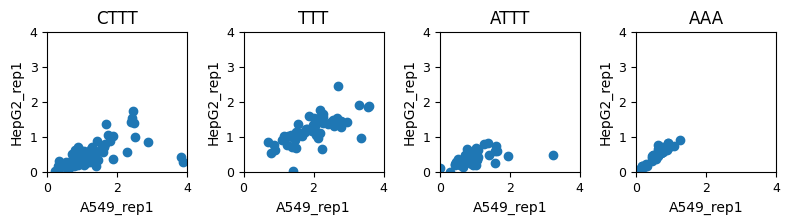

In [11]:
# Draw different motifs and differential expansions
def draw_figure(ax, X, Y, motif):
    subdf = df[df["N4"].str.startswith(motif)]
    ax.set_aspect("equal", "box")
    ax.scatter(subdf[X], subdf[Y])
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    ax.set_title(motif)
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    
fig, axes = plt.subplots(1, 4, figsize=(8, 3))

draw_figure(axes[0], "A549_rep1", "HepG2_rep1", "CTTT")
draw_figure(axes[1], "A549_rep1", "HepG2_rep1", "TTT")
draw_figure(axes[2], "A549_rep1", "HepG2_rep1", "ATTT")
draw_figure(axes[3], "A549_rep1", "HepG2_rep1", "AAA")
plt.tight_layout()